In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'traffic-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3860551%2F6696586%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T152050Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49d45d30dac3b3c7af53f3755fd396d2b595f7f4c75efcc62b3d2ae842d31325df8e60993b9117c80678e279708ca73ea47abc65c367617968a3c5737606d13a7ff2b4c57885b0f419b3f7c7bd362e630e8e487cf04f17b0095ca634db081cc8f862f3c7ffb36f3d273065f68697e8a07721afd3029dff152d043c940cde6cef9bb16fbf7cdfa26908e78af45fbb164ba9866f1e5ae8ef433d9097d9736fe6d5e1f5d1cb8cc73fcdca0f0498f43a6ff1e1b6dc93619fc937b155c90a2e81f505ff82e9bc464a1fca9165f794e6cfa8424feae4895bdaf8431ea8b6b3fe8ee909212a169fc56653699d8fabab40768d18f73d8bedd96e88e02a6233db1618f124'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 28753 bytes downloaded
Downloaded and uncompressed: traffic-prediction-dataset
Data source import complete.


# Traffic Prediction

## INDEX
- Initialisation & import
- Visualisation
- From scratch function
- Train
- Test
- Result

# Init Dataset & Import modules

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-prediction-dataset/Traffic.csv


In [3]:
df = pd.read_csv("/kaggle/input/traffic-prediction-dataset/Traffic.csv")

In [4]:
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [5]:
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# VISUALISATION

<Axes: >

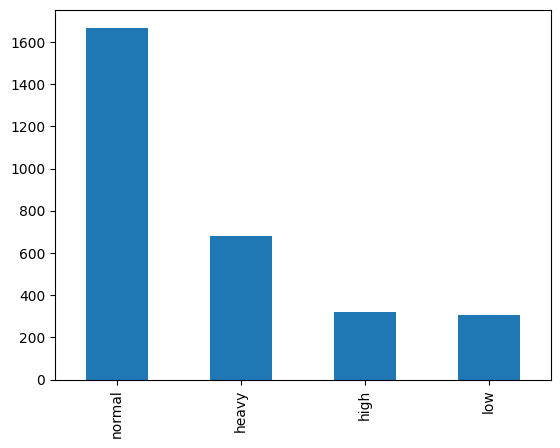

In [6]:
df['Traffic Situation'].value_counts().plot.bar()

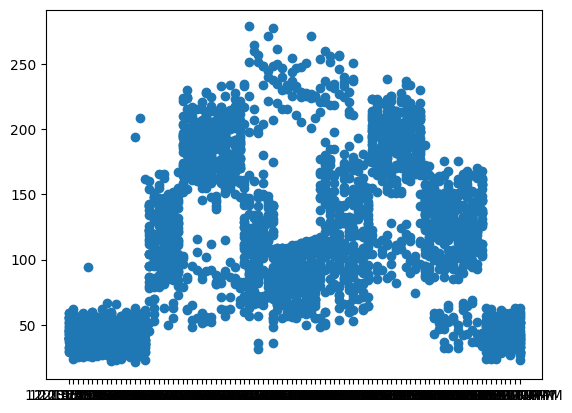

In [7]:
plt.plot_date(df['Time'], df['Total'])

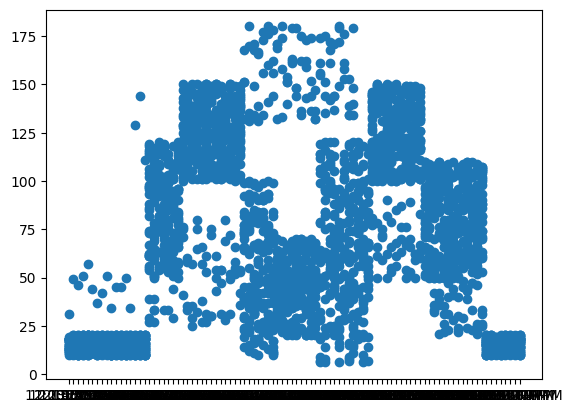

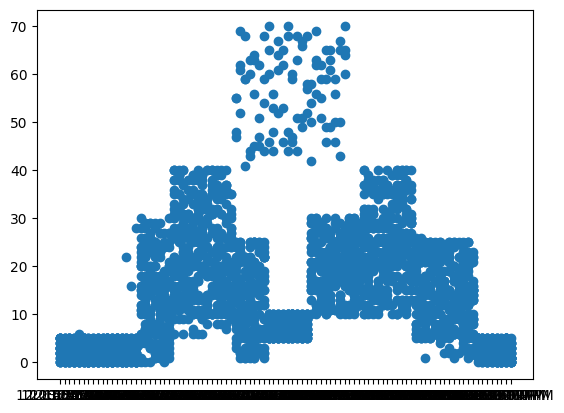

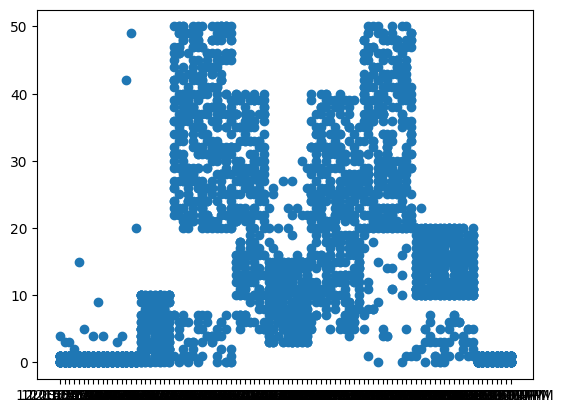

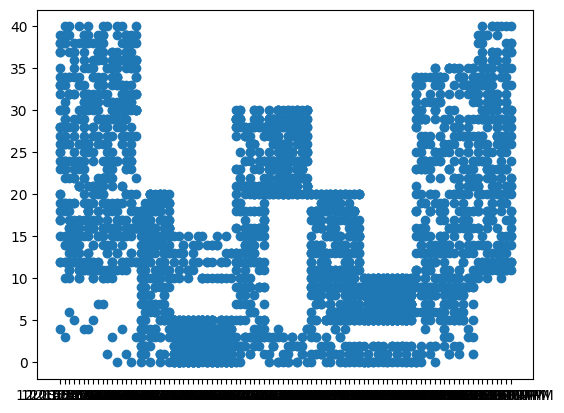

In [8]:
plt.plot_date(df['Time'], df['CarCount'])
plt.show()
plt.plot_date(df['Time'], df['BikeCount'])
plt.show()
plt.plot_date(df['Time'], df['BusCount'])
plt.show()
plt.plot_date(df['Time'], df['TruckCount'])
plt.show()

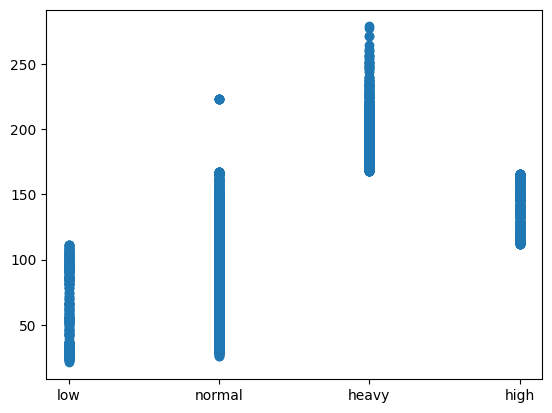

In [9]:
plt.scatter(df['Traffic Situation'], df['Total'])

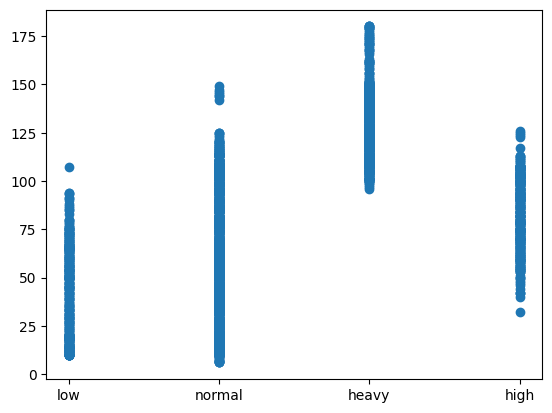

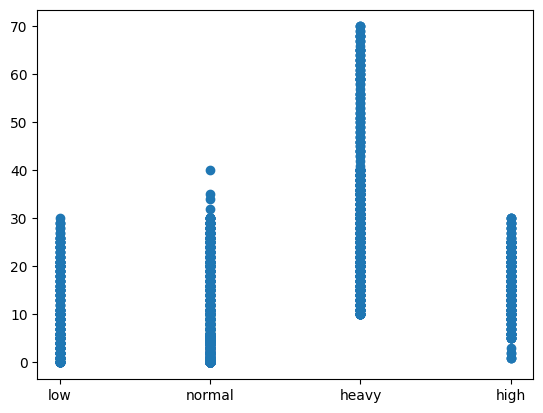

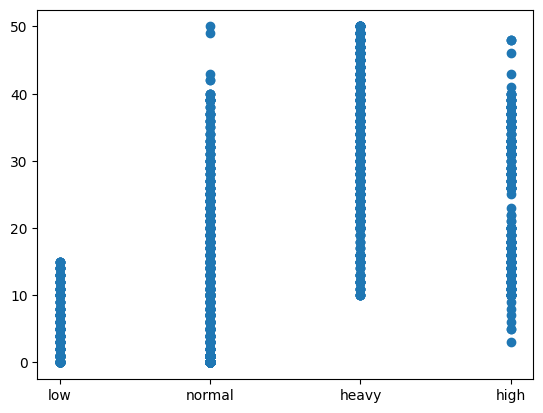

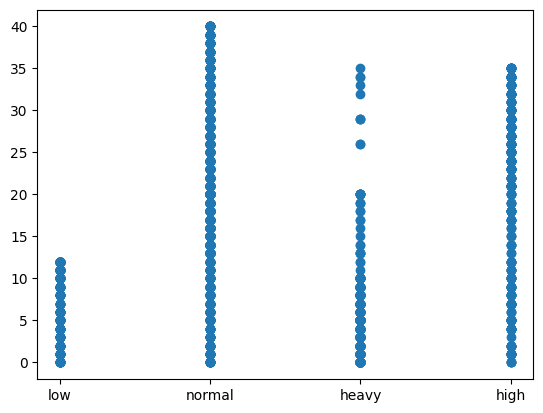

In [10]:
plt.scatter(df['Traffic Situation'], df['CarCount'])
plt.show()
plt.scatter(df['Traffic Situation'], df['BikeCount'])
plt.show()
plt.scatter(df['Traffic Situation'], df['BusCount'])
plt.show()
plt.scatter(df['Traffic Situation'], df['TruckCount'])
plt.show()

# FROM SCRATCH TRAINING FUNCTION

In [11]:
def sigmoid(x: float) -> float:
        return 1 / (1 + math.exp(-x))

In [12]:
def predict(input: list,w: list) -> float:
        output: float = 0
        for i in range(len(input)):
            output += w[i] * input[i]
        return sigmoid(output)

In [13]:
def train(inputs: list,target: int,w: list):
        output = predict(inputs,w)
        error = target - output
        for i in range(len(inputs)):
            w[i] += error * inputs[i] * 0.1
        return w

In [14]:
def initalization(n: int) -> list:
        w = []
        for i in range(n):
            w.append(random.random())
        return w

# Train
## Up the max_epoch for improve the model

In [15]:
TOTAL_COLLUMN: int = 8
LEARNING_RATE: float = 0.1
MAX_EPOCH: int = 10
POSSIBILITIES: list[str] = ['normal','heavy','high','low']

In [16]:
W: list = [initalization(TOTAL_COLLUMN) for i in range(len(POSSIBILITIES))]
W

[[0.25411602209969064,
  0.10117697677365078,
  0.12298331231608406,
  0.7204046648607434,
  0.7508791416148449,
  0.4818845077265632,
  0.5194208939784765,
  0.2642171688604802],
 [0.13528385035217705,
  0.954495925162676,
  0.2595077339355336,
  0.029290689608029385,
  0.8716832159020785,
  0.6319208485437785,
  0.6359568774176101,
  0.09689216550133628],
 [0.15440277565471117,
  0.13345935560024802,
  0.44470225182432277,
  0.003872929148719839,
  0.0019682433010212996,
  0.391810543469186,
  0.5714764184843821,
  0.3084844484388035],
 [0.10282958757220828,
  0.3127220330439765,
  0.5845400260632259,
  0.2934432928246694,
  0.6741699724463724,
  0.6386219600559172,
  0.3770994496183421,
  0.5504182702355567]]

In [17]:
for index_possibility in range(len(POSSIBILITIES)):
    for _ in tqdm(range(MAX_EPOCH)):
        for index_df in range(len(df)):
            time: int = int(df['Time'][0][0] + df['Time'][0][1])
            day_number: int = 0
            if df['Time'][0][-2] == 'P':
                time *= 2
            for day,_ in df['Day of the week'].value_counts().items():
                day_number += 1
                if day == df['Day of the week'][index_df] : break
            inputs: list = [
                time,
                df['Date'][index_df],
                day_number,
                df['CarCount'][index_df],
                df['BikeCount'][index_df],
                df['BusCount'][index_df],
                df['TruckCount'][index_df],
                df['Total'][index_df]
            ]
            for i in range(len(inputs)):
                inputs[i] /= 100
            target: int = POSSIBILITIES[index_possibility] == df['Traffic Situation'][index_df]
            W[index_possibility] = train(inputs,target,W[index_possibility])

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


In [18]:
W

[[5.128715725111752,
  4.315434544770822,
  1.0112381875801133,
  -0.855766922633372,
  0.3097575051914392,
  -4.464771839018443,
  6.477722419443007,
  -0.7414308763374874],
 [-12.774333942846901,
  -13.246055257190804,
  -3.3678237283964148,
  3.728621783496452,
  3.321492671782233,
  7.1905683703393635,
  -13.7359870003781,
  -1.5672636407302774],
 [-10.736182683144422,
  -9.494943074662444,
  -2.274062762239266,
  -1.171564589464162,
  -3.0720464294264898,
  4.321266164985372,
  1.578424546699461,
  0.9954360068296942],
 [5.18963099212502,
  5.055743816519395,
  2.239152103659253,
  5.4526767224759,
  3.7129586817420663,
  -4.104153245317067,
  -9.596205475877984,
  -5.967639721686735]]

# Test
## tests are performed on the first 100 values in the dataset

In [19]:
df_test = df[0:100]

In [20]:
performance:int = 0
for index_df_test in range(len(df_test)):
    for index_weight in range(len(W)):
        time: int = int(df_test['Time'][0][0] + df_test['Time'][0][1])
        day_number: int = 0
        if df['Time'][0][-2] == 'P':
            time *= 2
        for day,_ in df_test['Day of the week'].value_counts().items():
            day_number += 1
            if day == df_test['Day of the week'][index_df_test] : break
        inputs: list = [
                time,
                df_test['Date'][index_df_test],
                day_number,
                df_test['CarCount'][index_df_test],
                df_test['BikeCount'][index_df_test],
                df_test['BusCount'][index_df_test],
                df_test['TruckCount'][index_df_test],
                df_test['Total'][index_df_test]
            ]
        for i in range(len(inputs)):
                inputs[i] /= 100
        prediction = predict(inputs,W[index_weight])
        if prediction > .5:
            if POSSIBILITIES[index_weight] == df_test['Traffic Situation'][index_df_test]:
                performance += 1
            break
print(f"prediction rate {performance / 100} %")

prediction rate 0.55 %


## This last function is for display the result of this model with the futur dataset

In [21]:
def get_traffic_situation_by_df(df_test) -> None:
    for index_df_test in range(len(df_test)):
        for index_weight in range(len(W)):
            time: int = int(df_test['Time'][0][0] + df_test['Time'][0][1])
            day_number: int = 0
            if df['Time'][0][-2] == 'P':
                time *= 2
            for day,_ in df_test['Day of the week'].value_counts().items():
                day_number += 1
                if day == df_test['Day of the week'][index_df_test] : break
            inputs: list = [
                    time,
                    df_test['Date'][index_df_test],
                    day_number,
                    df_test['CarCount'][index_df_test],
                    df_test['BikeCount'][index_df_test],
                    df_test['BusCount'][index_df_test],
                    df_test['TruckCount'][index_df_test],
                    df_test['Total'][index_df_test]
                ]
            for i in range(len(inputs)):
                    inputs[i] /= 100
            prediction = predict(inputs,W[index_weight])
            if prediction > .5:
                print(POSSIBILITIES[index_weight])
                break